In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install openpyxl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/sinyal-gsr-1/Sinyal Sensor Polar HR HRV ECG.xlsx'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Akurasi model SVM: 85.16%


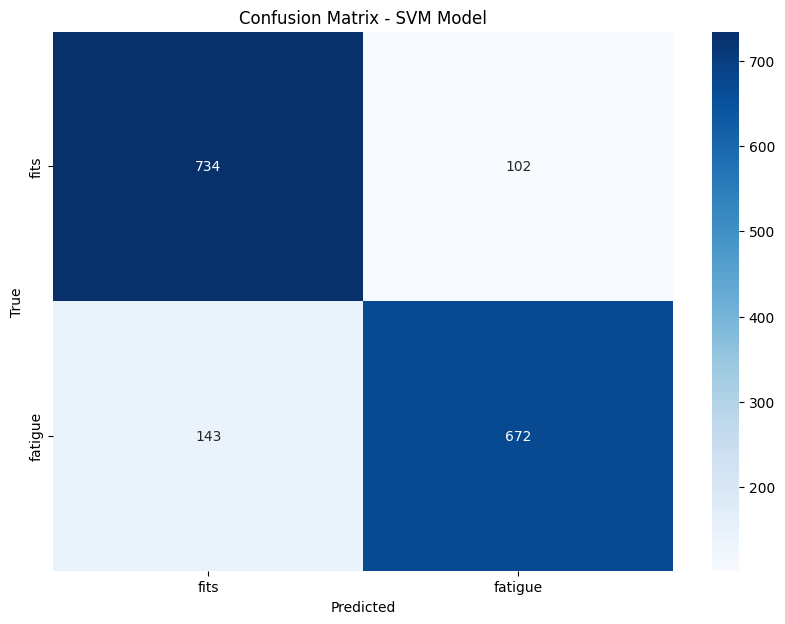

Classification Report:
               precision    recall  f1-score   support

        fits       0.84      0.88      0.86       836
     fatigue       0.87      0.82      0.85       815

    accuracy                           0.85      1651
   macro avg       0.85      0.85      0.85      1651
weighted avg       0.85      0.85      0.85      1651



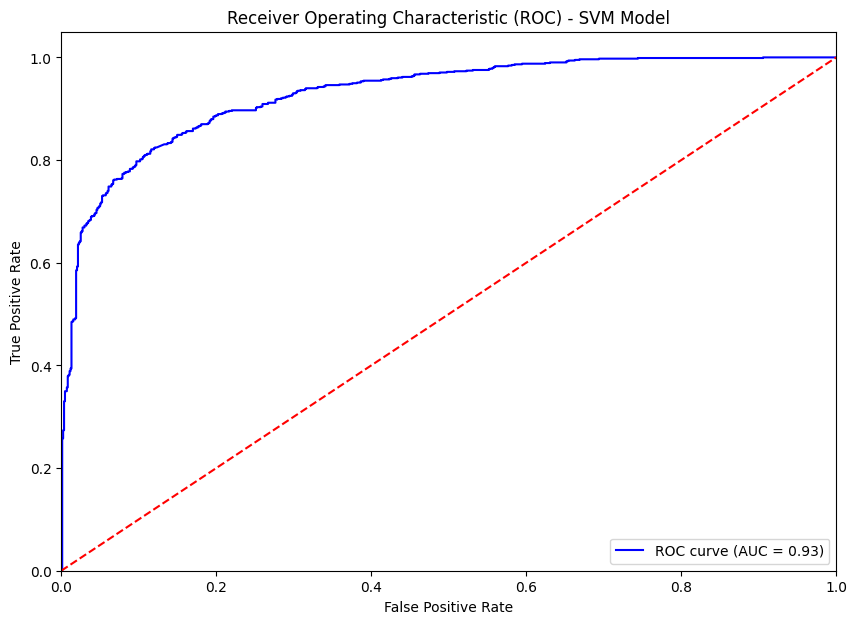

AUC Score: 0.93
Best Hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [9]:
# SVM 85,16% + AUROC 0,93 + train split 60:40
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Mengikuti behaviour untuk masa mendatang
pd.set_option('future.no_silent_downcasting', True)

# Load dataset (format .xlsx)
data = pd.read_excel('/kaggle/input/gsr-data-bersih/data_bersih_gsr.xlsx')

# Preprocessing: Memisahkan fitur dan label
X = data[['HR [bpm]', 'HRV [ms]', 'RR-interval [ms]']].copy()

# Menambahkan fitur statistik dari ECG
X['ecg_mean'] = data['ecg [uV]'].rolling(window=5).mean().bfill()
X['ecg_std'] = data['ecg [uV]'].rolling(window=5).std().bfill()
X['ecg_min'] = data['ecg [uV]'].rolling(window=5).min().bfill()
X['ecg_max'] = data['ecg [uV]'].rolling(window=5).max().bfill()

# Menghapus NaN yang mungkin tersisa setelah rolling window
X = X.dropna()

# Label (lelah atau bugar) dengan mapping
y = data['label'].replace({'bugar': 0, 'lelah': 1}).infer_objects(copy=False)

# Pastikan label sesuai dengan X
y = y[X.index]

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE untuk menangani imbalance kelas
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Bagi data menjadi data latih dan uji (60% latih, 40% uji)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

# Inisialisasi model SVM dengan hyperparameter tuning menggunakan GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': ['scale', 'auto'],        # Kernel coefficient
    'kernel': ['rbf', 'linear']        # Kernel type
}

grid = GridSearchCV(svm.SVC(probability=True), param_grid, refit=True, verbose=2, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Dapatkan model terbaik
best_model = grid.best_estimator_

# Evaluasi model terbaik
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi model SVM: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['fits', 'fatigue'], yticklabels=['fits', 'fatigue'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM Model')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['fits', 'fatigue'])
print("Classification Report:\n", class_report)

# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - SVM Model')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print(f'AUC Score: {roc_auc:.2f}')

# Print Best Hyperparameters
print(f'Best Hyperparameters: {grid.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.5s
[CV] END ...................C=0.1, gamma=auto, k

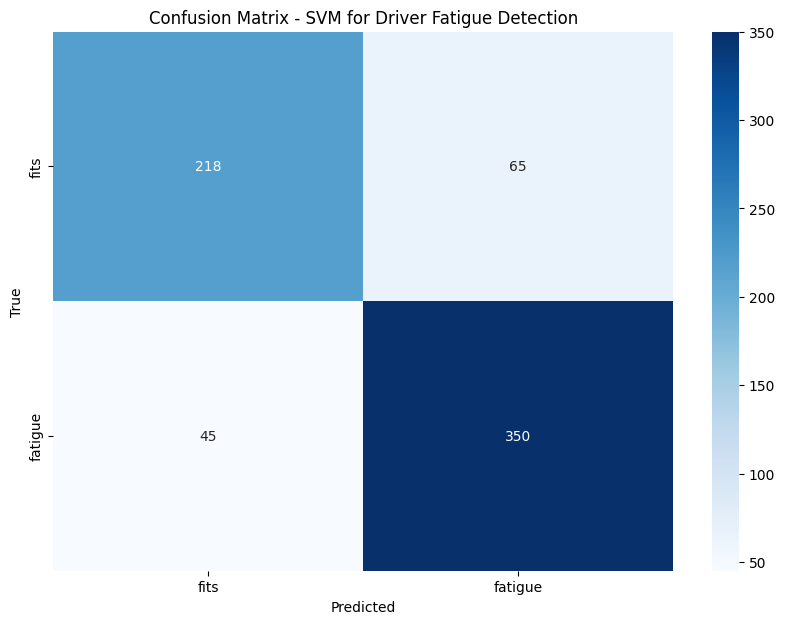

Classification Report:
               precision    recall  f1-score   support

        fits       0.83      0.77      0.80       283
     fatigue       0.84      0.89      0.86       395

    accuracy                           0.84       678
   macro avg       0.84      0.83      0.83       678
weighted avg       0.84      0.84      0.84       678



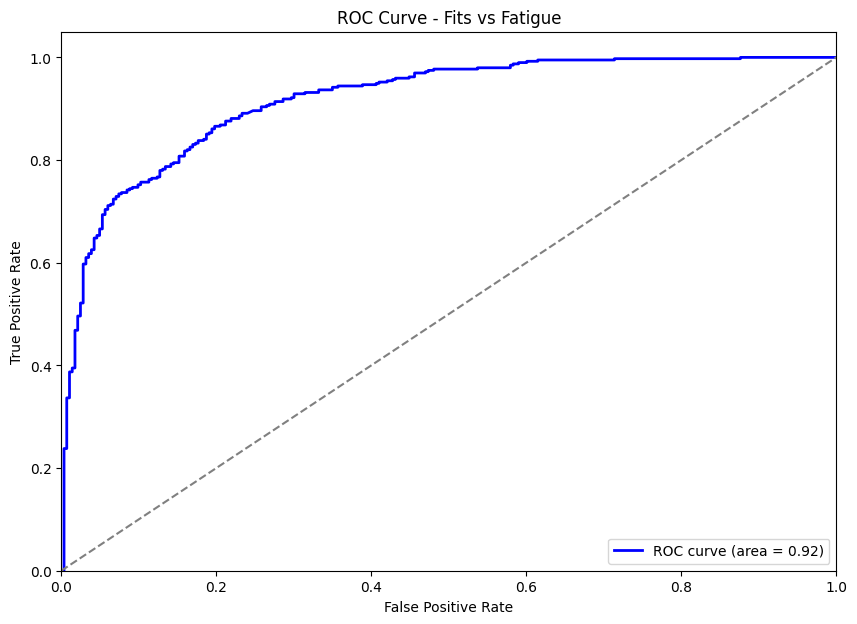

AUROC: 0.92
Prediksi kondisi: fatigue


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
# SVM Accuracy 83,78% + AUROC 92 + train split 80:20
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Mengikuti behaviour untuk masa mendatang
pd.set_option('future.no_silent_downcasting', True)

# Load dataset (format .xlsx)
data = pd.read_excel('/kaggle/input/gsr-data-bersih/data_bersih_gsr.xlsx')

# Preprocessing: Memisahkan fitur dan label
X = data[['HR [bpm]', 'HRV [ms]', 'RR-interval [ms]']].copy()

# Menambahkan fitur statistik dari ECG
X['ecg_mean'] = data['ecg [uV]'].rolling(window=5).mean().bfill()
X['ecg_std'] = data['ecg [uV]'].rolling(window=5).std().bfill()
X['ecg_min'] = data['ecg [uV]'].rolling(window=5).min().bfill()
X['ecg_max'] = data['ecg [uV]'].rolling(window=5).max().bfill()

# Menghapus NaN yang mungkin tersisa setelah rolling window
X = X.dropna()

# Label (lelah atau bugar) dengan mapping ke "fits" dan "fatigue"
y = data['label'].replace({'bugar': 0, 'lelah': 1}).infer_objects(copy=False)

# Pastikan label sesuai dengan X
y = y[X.index]

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data menjadi data latih dan uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Membangun model SVM dengan grid search untuk hyperparameter tuning
svm = SVC(probability=True)

# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(svm, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Evaluasi model terbaik
best_model = grid.best_estimator_
print(f"Model terbaik: {best_model}")

# Prediksi pada data uji
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas 1 (fatigue)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi model SVM: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['fits', 'fatigue'], yticklabels=['fits', 'fatigue'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM for Driver Fatigue Detection')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['fits', 'fatigue'])
print("Classification Report:\n", class_report)

# AUROC (ROC Curve & AUC Score)
# Menghitung ROC curve dan AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fits vs Fatigue')
plt.legend(loc="lower right")
plt.show()

# AUROC Mean (rata-rata AUC)
print(f'AUROC: {roc_auc:.2f}')

# Fungsi untuk prediksi real-time dengan SVM
def prediksi_real_time(hr_bpm, hrv_ms, rr_interval_ms, ecg_values):
    ecg_mean = np.mean(ecg_values)
    ecg_std = np.std(ecg_values)
    ecg_min = np.min(ecg_values)
    ecg_max = np.max(ecg_values)
    
    input_data = np.array([[hr_bpm, hrv_ms, rr_interval_ms, ecg_mean, ecg_std, ecg_min, ecg_max]])
    input_scaled = scaler.transform(input_data)
    prediksi = best_model.predict(input_scaled)
    label = ['fits', 'fatigue'][prediksi[0]]
    return label

# Contoh penggunaan prediksi real-time
ecg_values_example = [2737, 2188, 2354, 2312, 2060]
hasil = prediksi_real_time(114, 34, 1047, ecg_values_example)
print(f'Prediksi kondisi: {hasil}')